In [ ]:
%%shell
jupyter nbconvert --to html /content/X_Learner.ipynb

[NbConvertApp] Converting notebook /content/X_Learner.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 905921 bytes to /content/X_Learner.html


In [ ]:
import os, gc, json, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 120)
plt.rcParams["figure.figsize"] = (8,5)

In [ ]:
PATH = "Taxi_Trips.csv"

df = pd.read_csv(PATH, nrows=None, low_memory=False)

RENAME = {
    "Trip Start Timestamp": "start_ts",
    "Trip End Timestamp": "end_ts",
    "Trip Seconds": "mins",
    "Trip Miles": "miles",
    "Pickup Community Area": "pickup_ca",
    "Dropoff Community Area": "dropoff_ca",
    "Fare": "fare",
    "Tips": "tips",
    "Tolls": "tolls",
    "Extras": "extras",
    "Trip Total": "total",
    "Payment Type": "payment",
    "Company": "company",
    "Pickup Centroid Latitude": "pickup_ct_lat",
    "Pickup Centroid Longitude": "pickup_ct_lon",
    "Dropoff Centroid Latitude": "dropoff_ct_lat",
    "Dropoff Centroid Longitude": "dropoff_ct_lon",
}
df = df.rename(columns=RENAME)

In [ ]:
df.isna().mean()

,0
Trip ID,0.000000
Taxi ID,0.000001
start_ts,0.000000
end_ts,0.000009
mins,0.000195
miles,0.000007
Pickup Census Tract,0.621783
Dropoff Census Tract,0.637267
pickup_ca,0.026807
dropoff_ca,0.096912


In [ ]:
import folium
from sklearn.cluster import KMeans
from shapely import wkt
import numpy as np
import pandas as pd

def process_location(df, col_name, prefix):
    """Process location column: clean, cluster, and create features"""
    # Remove NaN
    print(f"{prefix} - Original rows: {len(df)}")
    df = df.dropna(subset=[col_name])

    # Extract coordinates
    def get_coords(s):
        try:
            p = wkt.loads(s)
            return [p.x, p.y]
        except:
            return [np.nan, np.nan]

    coords = np.array(df[col_name].apply(get_coords).tolist())
    valid_mask = ~np.isnan(coords).any(axis=1)
    df = df[valid_mask].copy()
    coords = coords[valid_mask]

    print(f"{prefix} - Valid rows: {len(df)}")

    # Create clusters
    kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
    df[f'{prefix}_cluster'] = kmeans.fit_predict(coords)

    print(f"{prefix} - Created {df[f'{prefix}_cluster'].nunique()} clusters\n")
    return df, kmeans

def create_map(df, col_name, prefix, top_n=200):
    """Create interactive map"""
    m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

    for point_str, count in df[col_name].value_counts().head(top_n).items():
        point = wkt.loads(point_str)
        color = 'red' if count > 50000 else 'orange' if count > 10000 else 'blue'

        folium.CircleMarker(
            location=[point.y, point.x],
            radius=min(count/5000, 20),
            popup=f'{count:,} {prefix}s',
            color=color,
            fill=True,
            fillOpacity=0.7
        ).add_to(m)

    filename = f'chicago_{prefix}s.html'

# Process both locations
df, dropoff_kmeans = process_location(df, 'Dropoff Centroid  Location', 'dropoff')
df, pickup_kmeans = process_location(df, 'Pickup Centroid Location', 'pickup')
create_map(df, 'Dropoff Centroid  Location', 'dropoff')
create_map(df, 'Pickup Centroid Location', 'pickup')

dropoff - Original rows: 865247
dropoff - Valid rows: 785572
dropoff - Created 20 clusters

pickup - Original rows: 785572
pickup - Valid rows: 779882
pickup - Created 20 clusters



<Axes: xlabel='pickup_cluster'>

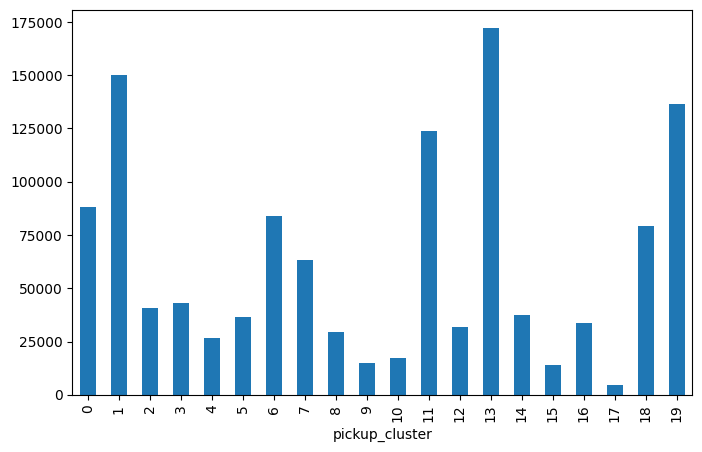

In [ ]:
df['dropoff_cluster'].value_counts().sort_index().plot.bar()
df['pickup_cluster'].value_counts().sort_index().plot.bar()

In [ ]:
for tcol in ["start_ts","end_ts"]:
    df[tcol] = pd.to_datetime(df[tcol], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")

df["mins"] = df["mins"] / 60.0

for c in ["miles","mins","fare","tips","tolls","extras","total"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# NEW FEATURE: Euclidean distance between pickup and dropoff locations
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between two points on Earth in miles"""
    R = 3959  # Earth radius in miles
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df["euclidean_distance"] = haversine_distance(
    df["pickup_ct_lat"], df["pickup_ct_lon"],
    df["dropoff_ct_lat"], df["dropoff_ct_lon"]
)

# Create distance ratio: how much longer is the actual trip vs straight-line distance
df["distance_ratio"] = np.where(
    (df["euclidean_distance"] > 0) & (df["miles"] > 0),
    df["miles"] / df["euclidean_distance"],
    np.nan
)

df["fare_per_mile"] = np.where((df["fare"].notna()) & (df["miles"]>0), df["fare"]/df["miles"], np.nan)
df["tip_rate"] = np.where((df["tips"].notna()) & (df["fare"]>0), df["tips"]/df["fare"], np.nan)
df["mph"] = df["miles"] / (df["mins"]/60.0)

df["date"] = df["start_ts"].dt.date
df["ymd"] = df["start_ts"].dt.to_period("D").astype(str)
df["dow"] = df["start_ts"].dt.dayofweek
df["hour"] = df["start_ts"].dt.hour
df["ts_hr"] = df["start_ts"].dt.floor("h")

df.describe()

,start_ts,end_ts,mins,miles,Pickup Census Tract,Dropoff Census Tract,pickup_ca,dropoff_ca,fare,tips,tolls,extras,total,pickup_ct_lat,pickup_ct_lon,dropoff_ct_lat,dropoff_ct_lon,dropoff_cluster,pickup_cluster,fare_per_mile,tip_rate,mph,dow,hour,ts_hr
count,779882,779882,779752.000000,779876.000000,3.125250e+05,3.125250e+05,779660.000000,775726.00000,778028.000000,778028.000000,778028.000000,778028.000000,778028.000000,779882.000000,779882.000000,779882.000000,779882.000000,779882.000000,779882.000000,701776.000000,776857.000000,7.676650e+05,779882.000000,779882.000000,779882
mean,2024-02-01 14:05:42.295245056,2024-02-01 14:24:25.690578944,18.470779,6.070591,1.703150e+10,1.703141e+10,34.635623,25.77553,20.620077,2.578647,0.050175,1.323114,24.745541,41.899279,-87.694532,41.892153,-87.659297,7.975139,9.933535,12.109958,0.142437,inf,2.684361,13.735029,2024-02-01 13:43:10.379569664
min,2024-01-01 00:00:00,2024-01-01 00:00:00,0.000000,0.000000,1.703101e+10,1.703101e+10,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,41.660136,-87.913625,41.650222,-87.913625,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,2024-01-01 00:00:00
25%,2024-01-18 14:15:00,2024-01-18 14:30:00,7.366667,0.900000,1.703108e+10,1.703108e+10,8.000000,8.00000,7.750000,0.000000,0.000000,0.000000,9.750000,41.878866,-87.708366,41.878866,-87.663518,2.000000,3.000000,2.658432,0.000000,8.400000e+00,1.000000,10.000000,2024-01-18 14:00:00
50%,2024-02-01 14:15:00,2024-02-01 14:30:00,14.100000,2.630000,1.703132e+10,1.703132e+10,32.000000,28.00000,13.750000,0.070000,0.000000,0.000000,16.500000,41.895033,-87.642498,41.892508,-87.633308,7.000000,11.000000,3.664495,0.010769,1.327374e+01,3.000000,14.000000,2024-02-01 14:00:00
75%,2024-02-16 12:30:00,2024-02-16 12:45:00,25.733333,11.210000,1.703198e+10,1.703184e+10,56.000000,32.00000,32.000000,3.650000,0.000000,1.000000,35.750000,41.965812,-87.625192,41.922686,-87.625192,13.000000,18.000000,6.081081,0.230986,2.554054e+01,4.000000,18.000000,2024-02-16 12:00:00
max,2024-03-01 00:00:00,2024-03-01 14:30:00,1439.000000,3093.470000,1.703198e+10,1.703198e+10,77.000000,77.00000,9999.750000,200.000000,4444.440000,5051.100000,9999.750000,42.021224,-87.534903,42.021224,-87.534903,19.000000,19.000000,100000.000000,910.000000,inf,6.000000,23.000000,2024-03-01 00:00:00
std,NaN,NaN,24.361131,7.554635,3.677273e+05,3.390069e+05,25.564095,20.43807,23.590175,3.743754,13.597918,18.780736,39.591547,0.064502,0.109175,0.059224,0.067579,5.417194,6.877684,169.225200,1.423271,NaN,1.841246,5.048129,NaN


In [ ]:
df = df[(df["miles"]>0) & (df["miles"]<200) & (df["mins"]>0) & (df["mins"]<600)]
df = df[(df["total"]>0) & (df["total"]<1000)]
df = df[(df["mph"] >= 5) & (df["mph"] <= 80)]

print(df.shape)
df.describe(percentiles=[.1,.5,.9,.95,.99])

(655463, 33)


,start_ts,end_ts,mins,miles,Pickup Census Tract,Dropoff Census Tract,pickup_ca,dropoff_ca,fare,tips,tolls,extras,total,pickup_ct_lat,pickup_ct_lon,dropoff_ct_lat,dropoff_ct_lon,dropoff_cluster,pickup_cluster,fare_per_mile,tip_rate,mph,dow,hour,ts_hr
count,655463,655463,655463.000000,655463.000000,2.618870e+05,2.618870e+05,655430.000000,651869.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655460.000000,655463.000000,655463.000000,655463.000000,655463
mean,2024-02-01 16:27:10.686095104,2024-02-01 16:46:05.770302464,18.892817,7.131897,1.703150e+10,1.703140e+10,34.999406,25.191683,21.162313,2.691909,0.003930,1.184499,25.239274,41.899959,-87.696099,41.891941,-87.656985,8.013078,10.015124,7.269049,0.143628,19.808005,2.675959,13.711996,2024-02-01 16:04:38.448669184
min,2024-01-01 00:00:00,2024-01-01 00:00:00,0.016667,0.010000,1.703101e+10,1.703101e+10,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.010000,41.660136,-87.913625,41.650222,-87.913625,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,2024-01-01 00:00:00
10%,2024-01-08 15:00:00,2024-01-08 15:30:00,5.000000,0.800000,1.703108e+10,1.703108e+10,8.000000,6.000000,5.750000,0.000000,0.000000,0.000000,7.000000,41.809084,-87.913625,41.812949,-87.711211,1.000000,0.000000,2.504174,0.000000,8.000000,0.000000,7.000000,2024-01-08 15:00:00
50%,2024-02-01 16:00:00,2024-02-01 16:30:00,15.083333,4.380000,1.703132e+10,1.703132e+10,32.000000,28.000000,15.000000,1.130000,0.000000,0.000000,17.500000,41.895033,-87.642498,41.892508,-87.633308,7.000000,11.000000,3.423913,0.114286,16.000000,3.000000,14.000000,2024-02-01 16:00:00
90%,2024-02-24 17:45:00,2024-02-24 18:00:00,37.466667,17.260000,1.703198e+10,1.703184e+10,76.000000,56.000000,43.500000,9.100000,0.000000,4.000000,55.250000,41.980264,-87.619711,41.975171,-87.618868,14.000000,19.000000,7.758621,0.320000,37.399293,5.000000,20.000000,2024-02-24 17:00:00
95%,2024-02-27 17:00:00,2024-02-27 17:15:00,45.450000,18.060000,1.703198e+10,1.703198e+10,76.000000,76.000000,45.750000,10.000000,0.000000,5.000000,59.400000,41.980264,-87.617358,41.982775,-87.615970,16.000000,19.000000,9.615385,0.413793,42.853879,6.000000,21.000000,2024-02-27 17:00:00
99%,2024-02-29 15:30:00,2024-02-29 15:45:00,61.616667,22.770000,1.703198e+10,1.703198e+10,77.000000,77.000000,60.500000,13.100000,0.000000,7.000000,72.500000,42.001571,-87.572782,42.005560,-87.572782,18.000000,19.000000,20.588235,0.666667,51.209370,6.000000,23.000000,2024-02-29 15:00:00
max,2024-03-01 00:00:00,2024-03-01 00:30:00,540.100000,135.570000,1.703198e+10,1.703198e+10,77.000000,77.000000,725.000000,200.000000,18.500000,300.000000,725.000000,42.021224,-87.534903,42.021224,-87.534903,19.000000,19.000000,22000.000000,910.000000,80.000000,6.000000,23.000000,2024-03-01 00:00:00
std,NaN,NaN,14.064800,6.543344,3.664798e+05,3.329976e+05,25.707183,19.952100,15.314208,3.718507,0.132361,2.367138,18.902407,0.064399,0.110849,0.058581,0.064067,5.430311,6.931609,93.706932,1.537683,11.678766,1.837490,5.012993,NaN


In [ ]:
hourly = (df.groupby("ts_hr")
         .agg(n_trips=("miles","size"),
              mean_fare_per_mile=("fare_per_mile","mean"),
              p90_fare_per_mile=("fare_per_mile", lambda x: np.nanpercentile(x,90)),
              mean_mph=("mph","mean"))
         .reset_index())

print(hourly.shape)
hourly

(1441, 5)


,ts_hr,n_trips,mean_fare_per_mile,p90_fare_per_mile,mean_mph
0,2024-01-01 00:00:00,282,48.080408,9.496970,19.613923
1,2024-01-01 01:00:00,367,27.521000,18.448905,15.517343
2,2024-01-01 02:00:00,330,102.867694,25.086207,17.350755
3,2024-01-01 03:00:00,171,10.745816,10.555556,18.222912
4,2024-01-01 04:00:00,84,18.977964,9.442512,20.250006
...,...,...,...,...,...
1436,2024-02-29 20:00:00,744,13.810180,6.250000,22.171112
1437,2024-02-29 21:00:00,506,18.464376,6.858917,24.904121
1438,2024-02-29 22:00:00,404,15.246935,7.446103,25.911199
1439,2024-02-29 23:00:00,301,15.652048,6.000000,28.592066


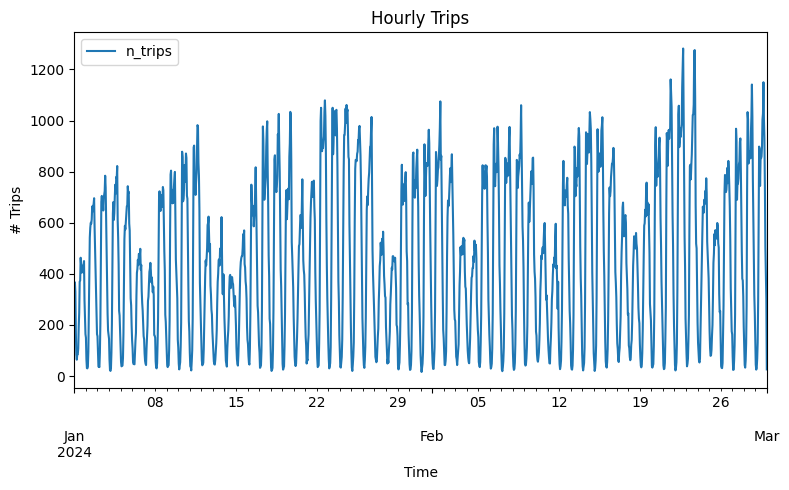

In [ ]:
hourly.plot(x="ts_hr", y="n_trips", title="Hourly Trips")
plt.xlabel("Time")
plt.ylabel("# Trips")
plt.tight_layout()
plt.show()

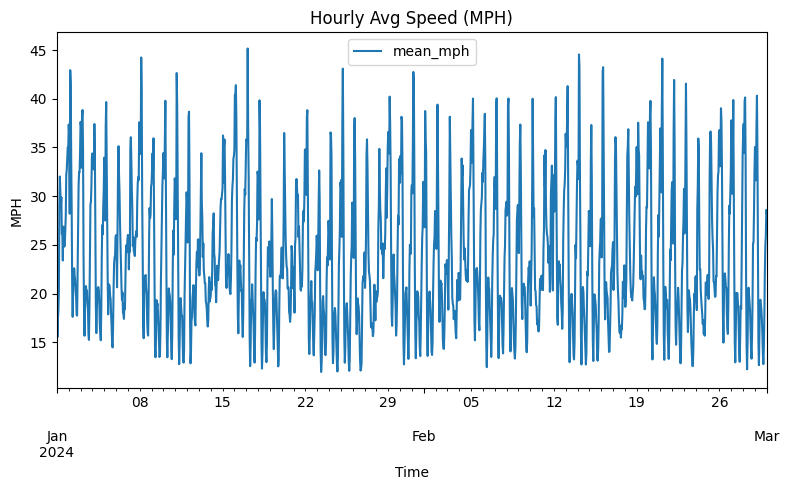

In [ ]:
hourly.plot(x="ts_hr", y="mean_mph", title="Hourly Avg Speed (MPH)")
plt.xlabel("Time"); plt.ylabel("MPH")
plt.tight_layout(); plt.show()

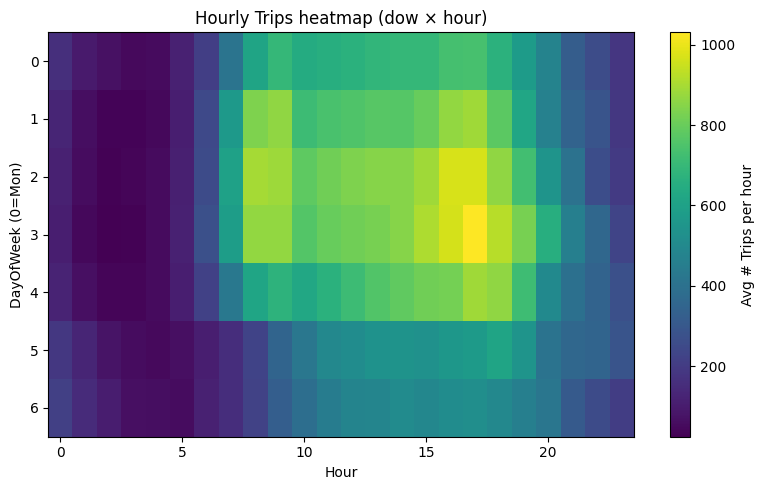

In [ ]:
hourly["dow"]  = hourly["ts_hr"].dt.dayofweek  # 0=Mon
hourly["hour"] = hourly["ts_hr"].dt.hour

pv_hr = (hourly
         .groupby(["dow","hour"])
         .agg(n_trips=("n_trips","mean"),
              fare_per_mile=("mean_fare_per_mile","mean"),
              mph=("mean_mph","mean"))
         .reset_index())

mat = pv_hr.pivot(index="dow", columns="hour", values="n_trips").fillna(0)

plt.imshow(mat, aspect="auto")
plt.title("Hourly Trips heatmap (dow × hour)")
plt.xlabel("Hour"); plt.ylabel("DayOfWeek (0=Mon)")
plt.colorbar(label="Avg # Trips per hour")
plt.tight_layout(); plt.show()

In [ ]:
df["is_weekday"] = df["dow"].between(0, 4).astype(int)
df["rush_hour"] = (
    df["is_weekday"].eq(1) &
    (
        df["hour"].between(7, 9) |
        df["hour"].between(16, 18)
    )
).astype(int)

df["rush_hour"].value_counts(normalize=True)

,proportion
rush_hour,
0,0.685874
1,0.314126


In [ ]:
def is_ord(lat, lon):
    return (lat.between(41.96, 42.01)) & (lon.between(-87.95, -87.85))

def is_mdw(lat, lon):
    return (lat.between(41.76, 41.81)) & (lon.between(-87.78, -87.71))

pickup_ord = is_ord(df["pickup_ct_lat"], df["pickup_ct_lon"])
dropoff_ord = is_ord(df["dropoff_ct_lat"], df["dropoff_ct_lon"])
pickup_mdw = is_mdw(df["pickup_ct_lat"], df["pickup_ct_lon"])
dropoff_mdw = is_mdw(df["dropoff_ct_lat"], df["dropoff_ct_lon"])

df["airport_trip"] = (
    pickup_ord | dropoff_ord | pickup_mdw | dropoff_mdw
).astype(int)

df["airport_trip"].value_counts(normalize=True)

,proportion
airport_trip,
0,0.730375
1,0.269625


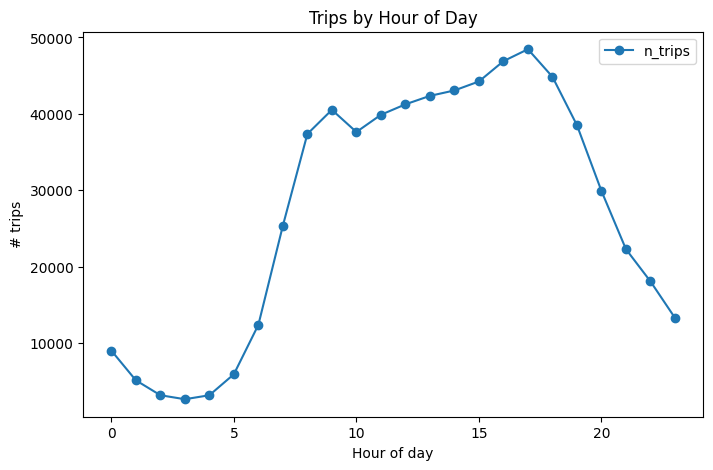

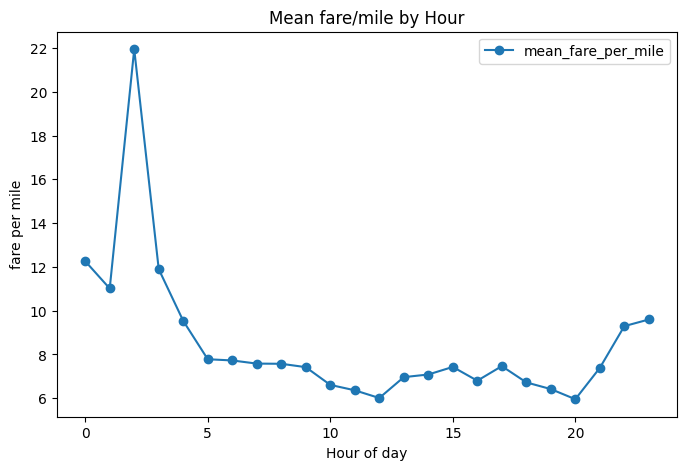

In [ ]:
hourly_trip = (df.groupby("hour")
                 .agg(n_trips=("Trip ID","size"),
                      mean_fare_per_mile=("fare_per_mile","mean"),
                      mean_mph=("mph","mean"))
                 .reset_index())

hourly_trip.plot(x="hour", y="n_trips", marker="o", title="Trips by Hour of Day")
plt.xlabel("Hour of day"); plt.ylabel("# trips")
plt.show()

hourly_trip.plot(x="hour", y="mean_fare_per_mile", marker="o",
                 title="Mean fare/mile by Hour")
plt.xlabel("Hour of day"); plt.ylabel("fare per mile")
plt.show()

          fare_per_mile                                     mph             \
                   mean    median        std   count       mean     median   
rush_hour                                                                    
0              7.292589  3.144219  96.557559  449565  21.827881  19.142857   
1              7.217651  4.245283  87.159556  205898  15.397737  12.284762   

                              
                 std   count  
rush_hour                     
0          12.343391  449565  
1           8.554254  205898  


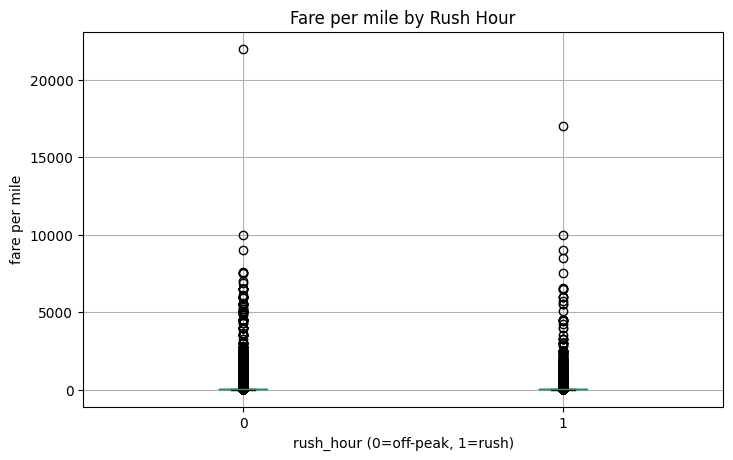

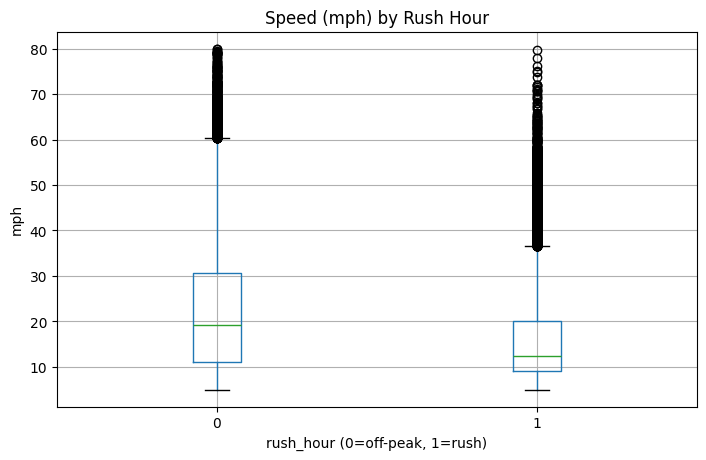

In [ ]:
summary_rush = (df.groupby("rush_hour")[["fare_per_mile","mph"]]
                  .agg(["mean","median","std","count"]))
print(summary_rush)

df.boxplot(column="fare_per_mile", by="rush_hour")
plt.title("Fare per mile by Rush Hour")
plt.suptitle("")
plt.xlabel("rush_hour (0=off-peak, 1=rush)")
plt.ylabel("fare per mile")
plt.show()

df.boxplot(column="mph", by="rush_hour")
plt.title("Speed (mph) by Rush Hour")
plt.suptitle("")
plt.xlabel("rush_hour (0=off-peak, 1=rush)")
plt.ylabel("mph")
plt.show()

99% quantile fare_per_mile: 20.588235294117645


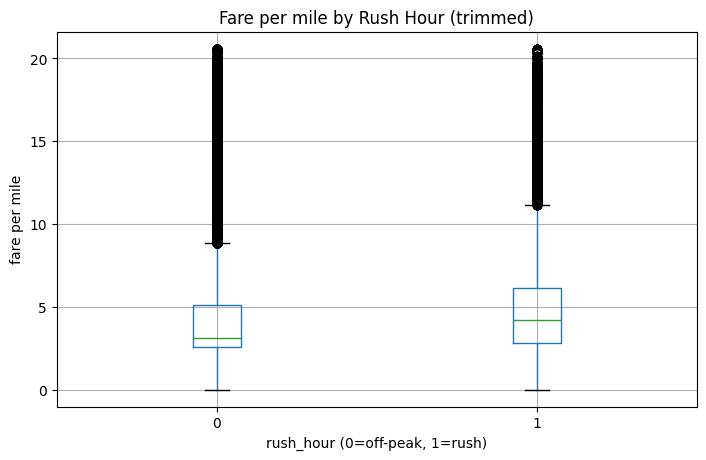

In [ ]:
df["fare_per_mile"].describe(percentiles=[.5, .9, .95, .99])
df["mph"].describe(percentiles=[.5, .9, .95, .99])

df = df[(df["mph"] > 0) & (df["mph"] <= 80)]

q99_fpm = df["fare_per_mile"].quantile(0.99)
print("99% quantile fare_per_mile:", q99_fpm)

cap_fpm = min(q99_fpm, 50)
df = df[df["fare_per_mile"] <= cap_fpm]

df.boxplot(column="fare_per_mile", by="rush_hour")
plt.title("Fare per mile by Rush Hour (trimmed)")
plt.suptitle("")
plt.xlabel("rush_hour (0=off-peak, 1=rush)")
plt.ylabel("fare per mile")
plt.show()


  rush_hour airport_trip fare_per_mile                mph        
                                  mean   count       mean   count
0         0            0      4.871711  309722  17.189103  309722
1         0            1      2.654574  135167  32.780588  135167
2         1            0      5.424989  163177  13.316235  163177
3         1            1      2.709805   40854  23.881009   40854


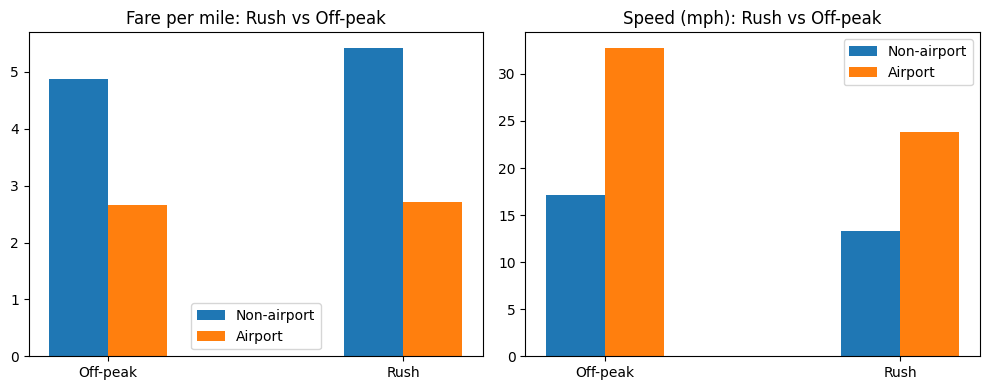

In [ ]:
tab = (df
       .groupby(["rush_hour","airport_trip"])[["fare_per_mile","mph"]]
       .agg(["mean","count"])
       .reset_index())
print(tab)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

# fare per mile
for a in [0,1]:
    sub = df[df["airport_trip"]==a]
    label = "Non-airport" if a==0 else "Airport"
    means = sub.groupby("rush_hour")["fare_per_mile"].mean()
    ax[0].bar([0+0.2*a,1+0.2*a], means, width=0.2, label=label)
ax[0].set_xticks([0.1,1.1])
ax[0].set_xticklabels(["Off-peak","Rush"])
ax[0].set_title("Fare per mile: Rush vs Off-peak")
ax[0].legend()

# mph
for a in [0,1]:
    sub = df[df["airport_trip"]==a]
    label = "Non-airport" if a==0 else "Airport"
    means = sub.groupby("rush_hour")["mph"].mean()
    ax[1].bar([0+0.2*a,1+0.2*a], means, width=0.2, label=label)
ax[1].set_xticks([0.1,1.1])
ax[1].set_xticklabels(["Off-peak","Rush"])
ax[1].set_title("Speed (mph): Rush vs Off-peak")
ax[1].legend()

plt.tight_layout()
plt.show()

# X-LEARNER


In [ ]:
!pip install econml

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from econml.metalearners import XLearner

In [ ]:
treatment_col = "airport_trip"
outcome_col = "fare_per_mile"

df = pd.get_dummies(df, columns=['company'], prefix='company')
df_sub = df.sample(n=50000, random_state=42)

covariates = [
    'dow', 'hour', 'pickup_cluster', 'dropoff_cluster', 'miles', 'rush_hour',
    'euclidean_distance', 'distance_ratio',  # NEW FEATURES
    'company_312 Medallion Management Corp',
    'company_3556 - 36214 RC Andrews Cab', 'company_3591 - 63480 Chuks Cab',
    'company_4053 - 40193 Adwar H. Nikola', 'company_5 Star Taxi',
    'company_5167 - 71969 5167 Taxi Inc', 'company_6574 - Babylon Express Inc.',
    'company_Blue Ribbon Taxi Association',
    'company_Blue Ribbon Taxi Association Inc.',
    'company_Chicago City Taxi Association', 'company_Chicago Independents',
    'company_Chicago Taxicab', 'company_Choice Taxi Association',
    'company_Choice Taxi Association Inc', 'company_City Service',
    'company_Flash Cab', 'company_Globe Taxi',
    'company_Koam Taxi Association', 'company_Medallion Leasin',
    'company_Metro Jet Taxi A.',
    'company_Patriot Taxi Dba Peace Taxi Associat',
    'company_Petani Cab Corp', 'company_Setare Inc',
    'company_Star North Taxi Management Llc', 'company_Sun Taxi',
    'company_Tac - Checker Cab Dispatch',
    'company_Tac - Yellow Cab Association',
    'company_Taxi Affiliation Services',
    'company_Taxi Affiliation Services Llc - Yell',
    'company_Taxicab Insurance Agency Llc',
    'company_Taxicab Insurance Agency, LLC', 'company_Top Cab',
    'company_U Taxicab', 'company_2733 - 74600 Benny Jona'
]

X = df_sub[covariates].fillna(0).values
T = df_sub[treatment_col].astype(int).fillna(0).values
Y = df_sub[outcome_col].fillna(df_sub[outcome_col].median()).values

In [ ]:
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.3, random_state=42
)

xl = XLearner(
    models=RandomForestRegressor(n_estimators=200),
    propensity_model=RandomForestClassifier(n_estimators=200)
)

xl.fit(Y_train, T_train, X=X_train)

tau_hat = xl.effect(X_test)

ATE = tau_hat.mean()
print("ATE:", ATE)

B = 200
boot = []
n = len(tau_hat)

for b in range(B):
    idx = np.random.choice(n, n, replace=True)
    boot.append(tau_hat[idx].mean())

ci_low, ci_high = np.percentile(boot, [2.5, 97.5])
print(f"95% CI: [{ci_low:.4f}, {ci_high:.4f}]")

ATT = tau_hat[T_test == 1].mean()
ATC = tau_hat[T_test == 0].mean()

print("ATT:", ATT)
print("ATC:", ATC)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ATE: -0.07324906875450735
95% CI: [-0.0842, -0.0578]
ATT: -0.11105534920546112
ATC: -0.05939801574177861


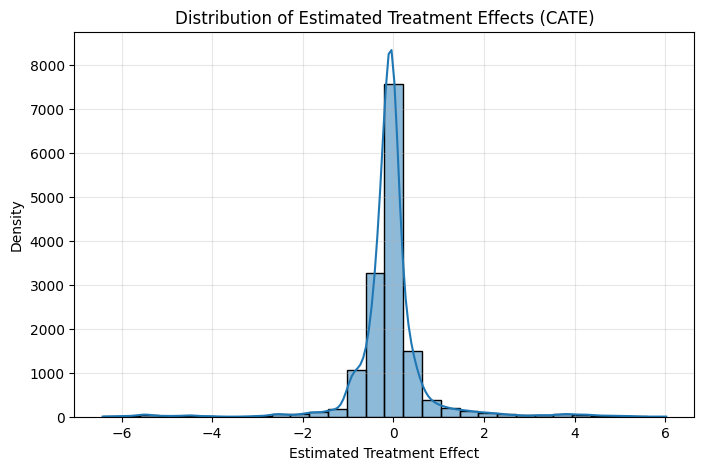

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(tau_hat, kde=True, bins=30)
plt.title("Distribution of Estimated Treatment Effects (CATE)")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()


/tmp/ipython-input-2236866675.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_vis[df_vis['airport_trip']==1]['fare_per_mile'], label="Airport", shade=True)
/tmp/ipython-input-2236866675.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_vis[df_vis['airport_trip']==0]['fare_per_mile'], label="Non-Airport", shade=True)


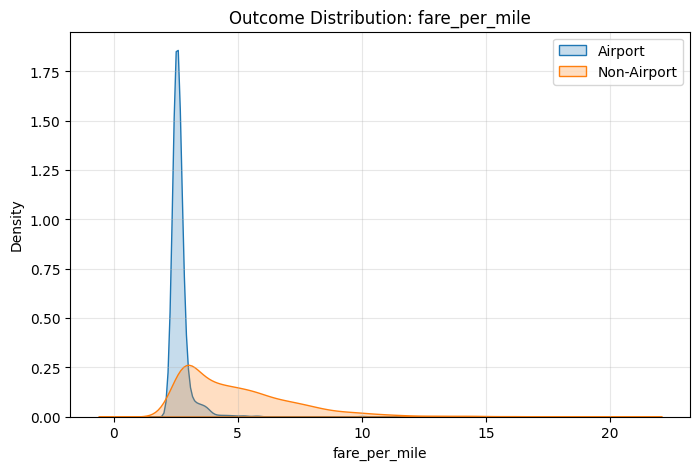

In [ ]:
df_vis = df_sub.sample(5000)
plt.figure(figsize=(8,5))
sns.kdeplot(df_vis[df_vis['airport_trip']==1]['fare_per_mile'], label="Airport", shade=True)
sns.kdeplot(df_vis[df_vis['airport_trip']==0]['fare_per_mile'], label="Non-Airport", shade=True)
plt.title("Outcome Distribution: fare_per_mile")
plt.xlabel("fare_per_mile")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

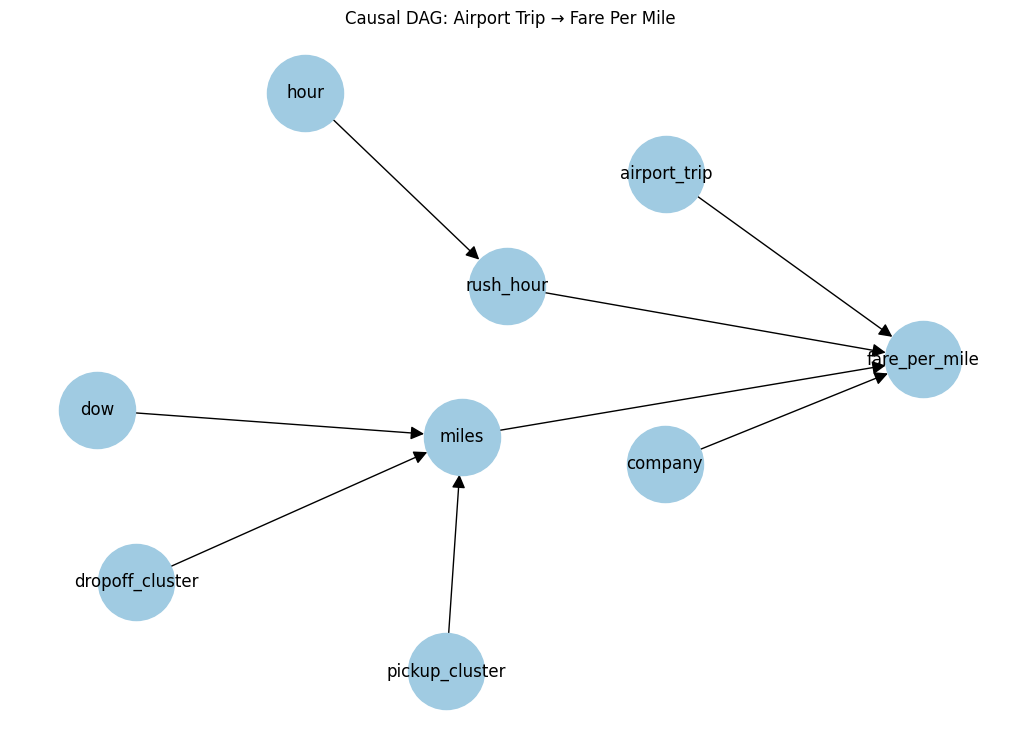

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

G.add_edges_from([
    ("airport_trip", "fare_per_mile"),
    ("miles", "fare_per_mile"),
    ("rush_hour", "fare_per_mile"),
    ("hour", "rush_hour"),
    ("dow", "miles"),
    ("pickup_cluster", "miles"),
    ("dropoff_cluster", "miles"),
    ("company", "fare_per_mile")
])

plt.figure(figsize=(10,7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="#A0CBE2", arrowsize=20)
plt.title("Causal DAG: Airport Trip → Fare Per Mile")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-3184467825.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(propensity[T_train==1], label="Treated", shade=True)
/tmp/ipython-input-3184467825.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(propensity[T_train==0]

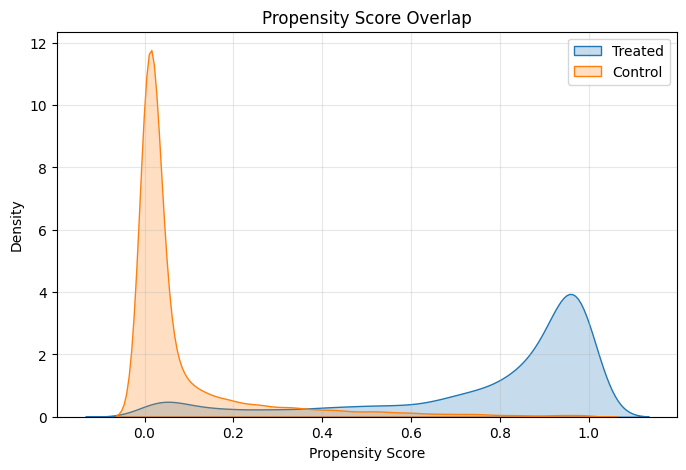

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Compute propensity scores
logit = LogisticRegression(max_iter=200)
propensity = logit.fit(X_train, T_train).predict_proba(X_train)[:,1]

# Plot overlap
plt.figure(figsize=(8,5))
sns.kdeplot(propensity[T_train==1], label="Treated", shade=True)
sns.kdeplot(propensity[T_train==0], label="Control", shade=True)
plt.title("Propensity Score Overlap")
plt.xlabel("Propensity Score")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


## Model Validation

In [ ]:
import numpy as np
import pandas as pd

def standardized_mean_difference(df, T, covariates):
    res = {}
    treated = df[T == 1]
    control = df[T == 0]

    for c in covariates:
        m1, m0 = treated[c].mean(), control[c].mean()
        s1, s0 = treated[c].std(), control[c].std()
        smd = (m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)
        res[c] = smd
    return pd.Series(res).sort_values()

smd = standardized_mean_difference(df_sub, df_sub['airport_trip'], covariates)
print(smd)


company_Flash Cab                              -0.407873
rush_hour                                      -0.255980
dropoff_cluster                                -0.174551
company_Blue Ribbon Taxi Association           -0.064793
company_Tac - Yellow Cab Association           -0.063650
pickup_cluster                                 -0.049672
company_Koam Taxi Association                  -0.047787
company_3591 - 63480 Chuks Cab                 -0.044957
company_Chicago City Taxi Association          -0.042136
company_3556 - 36214 RC Andrews Cab            -0.037021
company_Tac - Checker Cab Dispatch             -0.031401
company_Patriot Taxi Dba Peace Taxi Associat   -0.024500
company_Metro Jet Taxi A.                      -0.012805
company_Taxi Affiliation Services Llc - Yell   -0.009408
company_Blue Ribbon Taxi Association Inc.      -0.007402
company_Globe Taxi                             -0.003617
company_U Taxicab                              -0.002599
company_Taxi Affiliation Servic

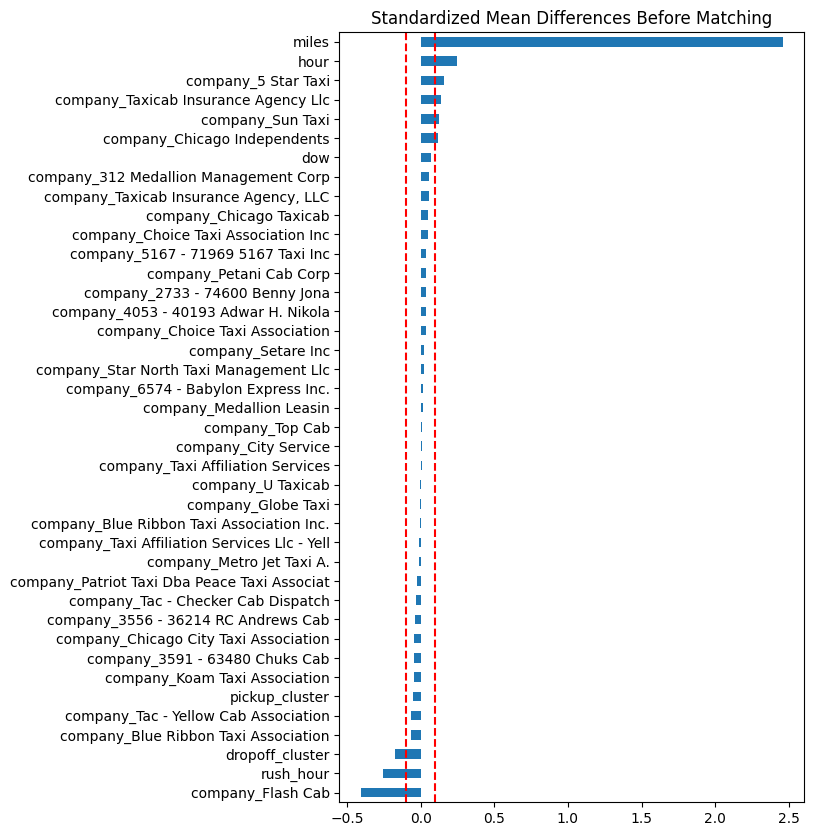

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,10))
smd.plot(kind='barh')
plt.title("Standardized Mean Differences Before Matching")
plt.axvline(0.1, color='red', linestyle='--')
plt.axvline(-0.1, color='red', linestyle='--')
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipython-input-3070841723.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(propensity[T_train==1], label="Treated", shade=True)
/tmp/ipython-input-3070841723.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(propensity[T_train==0], 

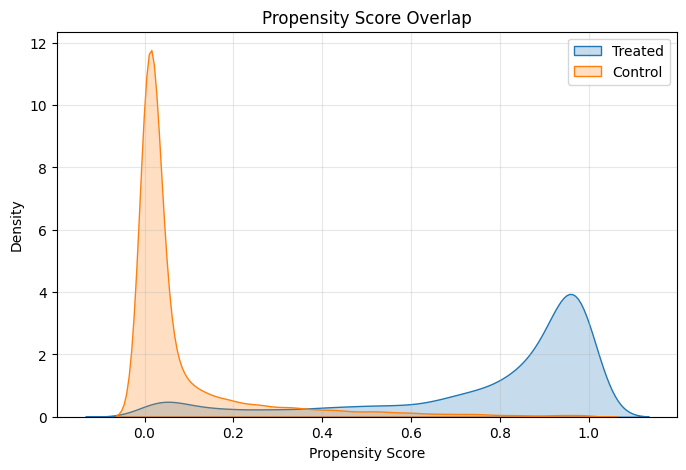

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns

logit = LogisticRegression(max_iter=200)
propensity = logit.fit(X_train, T_train).predict_proba(X_train)[:,1]

plt.figure(figsize=(8,5))
sns.kdeplot(propensity[T_train==1], label="Treated", shade=True)
sns.kdeplot(propensity[T_train==0], label="Control", shade=True)
plt.title("Propensity Score Overlap")
plt.xlabel("Propensity Score")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [ ]:
print("Treated PS range:", propensity[T_train==1].min(), "to", propensity[T_train==1].max())
print("Control PS range:", propensity[T_train==0].min(), "to", propensity[T_train==0].max())


Treated PS range: 0.0008599374590561003 to 0.9999999999863822
Control PS range: 0.00026591822237383297 to 0.999999999984494


In [ ]:
from sklearn.metrics import mean_squared_error

# Fit simple outcome model
y_model = RandomForestRegressor(n_estimators=100)
y_model.fit(X_train, Y_train)

y_pred = y_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

print("RMSE of Outcome Model:", rmse)

RMSE of Outcome Model: 0.9135159750112924


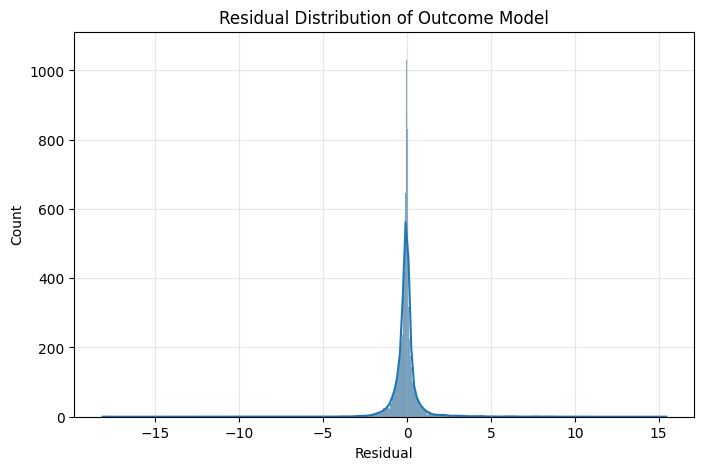

In [ ]:
residuals = Y_test - y_pred

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution of Outcome Model")
plt.xlabel("Residual")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from econml.metalearners import XLearner

# ---- Placebo Test ----

np.random.seed(42)
fake_treat = np.random.binomial(1, 0.5, size=len(df_sub))

X_train_p, X_test_p, T_train_p, T_test_p, Y_train_p, Y_test_p = train_test_split(
    X, fake_treat, Y, test_size=0.3, random_state=42
)

xl_placebo = XLearner(
    models=LinearRegression(),
    propensity_model=LogisticRegression()
)

xl_placebo.fit(Y_train_p, T_train_p, X=X_train_p)

tau_fake = xl_placebo.effect(X_test_p)
print("Placebo ATE (should be near 0):", tau_fake.mean())


Placebo ATE (should be near 0): -0.013874492768136133


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
cov_small = ['miles', 'rush_hour', 'dow', 'hour']
X_small = df_sub[cov_small].fillna(0).values

X_train_s, X_test_s, T_train_s, T_test_s, Y_train_s, Y_test_s = train_test_split(
    X_small, T, Y, test_size=0.3, random_state=42
)

xl_small = XLearner(
    models=LinearRegression(),
    propensity_model=LogisticRegression(max_iter=200)
)

xl_small.fit(Y_train_s, T_train_s, X=X_train_s)

ATE_s = xl_small.effect(X_test_s).mean()

print("ATE (reduced covariates):", ATE_s)
print("ATE (full covariates):", ATE)

ATE (reduced covariates): -0.6769763396694405
ATE (full covariates): -0.07324906875450735


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
